#### A2.1 Regresión logística y validación cruzada

Inciso 1

En este primer bloque de código se importó la base de datos A2.1.csv (spotifydataset.csv) y se limpió siguiendo la misma lógica que se usó en el proyecto del primer parcial, con el objetivo de obtener una base de datos que se pueda procesar.

Además, se binarizó la variable de salida popularity usando la mediana: si la popularidad de un dato estaba por encima de la mediana (48), se consideraba popular (1), y si estaba por debajo, no popular (0). Esto se hizo para evitar que los outliers afectaran el valor de corte, como lo habría hecho el promedio.

Al finalizar, se imprimió el head del dataframe final para visualizar los datos listos para su procesamiento.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, roc_curve, roc_auc_score, ConfusionMatrixDisplay
%matplotlib inline
# Importar datos
df = pd.read_csv("A2.1.csv")

# Eliminar características no funcionales
df = df.drop(['Unnamed: 0', 'track_id', 'artists', 'album_name', 'track_name'], axis=1)

# Generar dummies para track_genre
genre_dummies = pd.get_dummies(df['track_genre'], prefix='genre')
df = pd.concat([df, genre_dummies], axis=1)
df = df.drop('track_genre', axis=1)

# Generar variables dummies para key
key_dummies = pd.get_dummies(df['key'], prefix='key')
df = pd.concat([df, key_dummies], axis=1)
df = df.drop('key', axis=1)

# Limitar base de datos canciones de pop
pop_columns = [col for col in df.columns if col.startswith('genre') and 'pop' in col.lower()]
mask = df[pop_columns].any(axis=1)
df = df[mask].reset_index(drop=True)
genre_columns = [col for col in df.columns if col.startswith('genre_')]
df = df.drop(columns=genre_columns)

# Volver True = 1 y False = 0
# Explicit
df['explicit'] = df['explicit'].astype('int8')
# Keys
key_cols = [col for col in df.columns if col.startswith('key_')]
for col in key_cols:
    df[col] = df[col].astype('int8')

# Revisar outliers en duración
q1=df.duration_ms.quantile(0.25)
q3=df.duration_ms.quantile(0.75)
iqr=q3-q1
li=q1-(3*iqr)
ls=q3+(3*iqr)
out=np.where((df.duration_ms<=li) | (df.duration_ms>=ls))[0]
print("Outliers de duración:")
print(df.iloc[out])

# Limitar la duración de canciones entre 60,000 (1 min) - 600,000 (10 min)
df = df[(df['duration_ms'] >= 60000) & (df['duration_ms'] <= 600000)].copy()
df = df.reset_index(drop=True)

# Búsqueda de variables con corelación
cor=abs(np.corrcoef(df,rowvar=False))
np.fill_diagonal(cor,0)
i,j=np.unravel_index(cor.argmax(),cor.shape)
print("Variables con mayor correlación (índices): ",i,j)
print("Variables con mayor correlación (nombre): ", df.columns[i], df.columns[j])
print("Valor de correlación absoluta: ",cor[i,j])
df = df.drop('loudness', axis=1)

# Binarizar popularity con ayuda de la mediana
median_popularity = df['popularity'].median()
print("Mediana de variable popularity: ", median_popularity)
df['popularity_binary'] = (df['popularity'] > median_popularity).astype('int8')
df = df.drop('popularity', axis=1)

# Dataframe final
print("Dataframe final:\n",df.head(10))

Outliers de duración:
      popularity  duration_ms  explicit  danceability  energy  loudness  mode  \
568           48       758307         0         0.437   0.473    -7.669     1   
689           40       601144         0         0.269   0.338   -12.757     1   
1663          40       548571         0         0.559   0.427   -12.228     1   
2008          66       537653         0         0.372   0.426    -8.421     1   
2992          36       605100         0         0.329   0.410   -11.870     1   
3256          13       946552         0         0.364   0.194   -14.938     1   
3325          54       541346         0         0.403   0.439   -15.154     0   
3468          52       519360         0         0.656   0.810    -7.448     1   
3475          53      3340672         0         0.719   0.466    -9.153     1   
3551          66       537653         0         0.372   0.426    -8.421     1   
3553          49      1613160         0         0.586   0.411   -11.425     1   
3616  

Inciso 2

En este bloque se divide la base de datos en train y test con una proporción de 80/20, respectivamente.
Dentro del train_test_split se utilizó el parámetro stratify sobre popularity_binary para asegurar que la proporción de clases 0 y 1 se mantuviera tanto en el conjunto de entrenamiento como en el de prueba.

Posteriormente, se verificó esta proporción calculando los porcentajes de cada clase en el dataframe original, en train y en test, asegurando que la división mantuviera la distribución de la variable de salida.

In [2]:
train, test = train_test_split(df, train_size=0.8, random_state=42, stratify=df['popularity_binary']) 
X_train = train.drop('popularity_binary', axis=1)
Y_train = train['popularity_binary']
X_test = test.drop('popularity_binary', axis=1)
Y_test = test['popularity_binary']

print("Clase 0 (%)")
print("Original: ", (df['popularity_binary'] == 0).mean() * 100)
print("Train: ", (Y_train == 0).mean() * 100)
print("Test: ", (Y_test == 0).mean() * 100)

print("\nClase 1 (%)")
print("Original: ", (df['popularity_binary'] == 1).mean() * 100)
print("Train: ", (Y_train == 1).mean() * 100)
print("Test: ", (Y_test == 1).mean() * 100)

Clase 0 (%)
Original:  50.913954525189475
Train:  50.91263759230876
Test:  50.9192200557103

Clase 1 (%)
Original:  49.08604547481052
Train:  49.08736240769124
Test:  49.080779944289695


Inciso 3

En este bloque de código se utiliza la función LogisticRegression para generar un modelo de regresión logística, que se ajusta a los datos de entrenamiento (X_train y Y_train). Es de resaltar que, dentro de los parámetro de la función se agregó max_iter=6000 para incrementar el número máximo de iteraciones que el algoritmo puede realizar para converger.

Para evaluar el desempeño del modelo se utilizó validación cruzada mediante la función cross_val_score con k-fold de 5 (cv=5). Esto significa que los datos de entrenamiento se dividieron en cinco subconjuntos, entrenando el modelo cinco veces: en cada iteración, un subconjunto se usa como validación y los otros cuatro como entrenamiento. El parámetro scoring='accuracy' indica que se evaluará el modelo usando la exactitud. Finalmente, se imprimen los resultados de cada fold y su promedio general.

In [3]:
model = LogisticRegression(penalty=None, class_weight="balanced", max_iter=6000)
scores = cross_val_score(model, X_train, Y_train, cv=5, scoring='accuracy')
print("Scores por fold:", scores)
print("Media:", scores.mean())

Scores por fold: [0.62256267 0.6051532  0.5902439  0.59930314 0.63135889]
Media: 0.6097243601564547


Inciso 4

En este bloque se evalúa el modelo de regresión logística usando los datos de prueba (X_train y Y_train). Después de entrenar el modelo con penalty=None, class_weight="balanced" y max_iter=6000, se calculan las probabilidades de que cada dato pertenezca a la clase 1 (que si es popular la canción).

Se usan tres umbrales diferentes (0.5, 0.8 y 0.3) para convertir las probabilidades en predicciones binarias. Para cada umbral se calcula la matriz de confusión, a partir de la cual se obtienen las métricas:
- Exactitud: proporción de predicciones correctas.
- Sensibilidad: proporción de casos positivos correctamente identificados.
- Especificidad: proporción de casos negativos correctamente identificados.


Resultados con umbral = 0.5


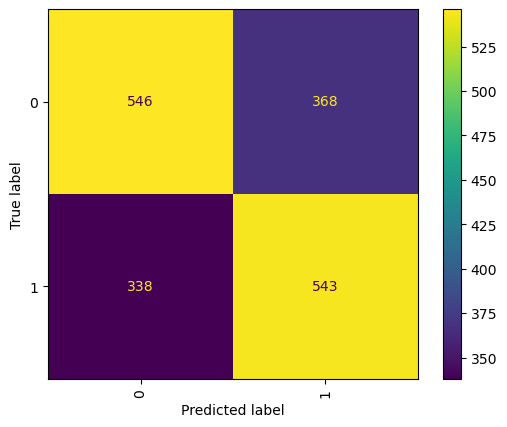

Exactitud:  0.6066852367688023
Sensibilidad:  0.6163450624290578
Especificidad:  0.5973741794310722

Resultados con umbral = 0.8


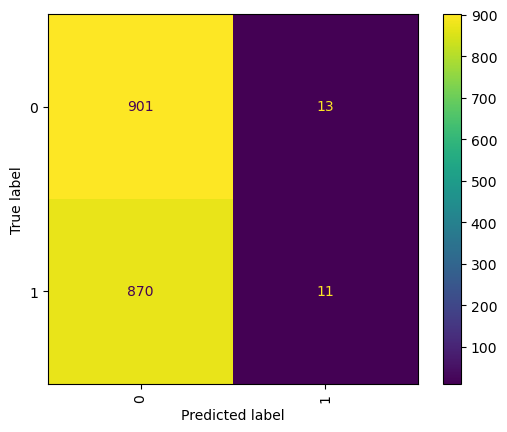

Exactitud:  0.5080779944289694
Sensibilidad:  0.012485811577752554
Especificidad:  0.9857768052516411

Resultados con umbral = 0.3


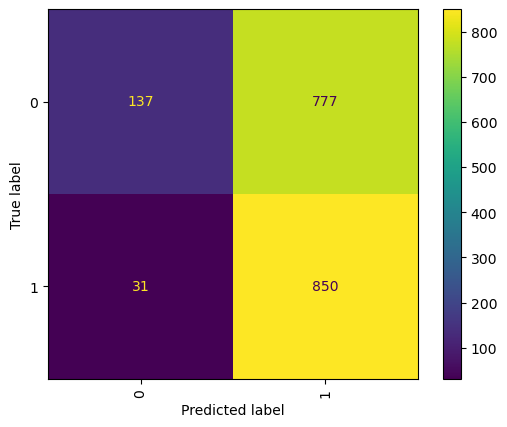

Exactitud:  0.5498607242339832
Sensibilidad:  0.9648127128263337
Especificidad:  0.14989059080962802


In [8]:
model = model.fit(X_train, Y_train)
probs = model.predict_proba(X_test)[:, 1]
umbrales = [0.5, 0.8, 0.3]

for t in umbrales:
    print("\nResultados con umbral =", t)
    preds = (probs >= t).astype(int)
    cm = confusion_matrix(Y_test, preds)
    tn, fp, fn, tp = cm.ravel()
    exactitud = (tp + tn) / (tp + tn + fp + fn)
    sensibilidad = tp / (tp + fn)
    especificidad = tn / (tn + fp)           
    ConfusionMatrixDisplay(confusion_matrix= cm,display_labels=model.classes_).plot(xticks_rotation="vertical")
    plt.show()
    print("Exactitud: ", exactitud)
    print("Sensibilidad: ", sensibilidad)
    print("Especificidad: ", especificidad)

Inciso 5

En este bloque de código se genera la curva ROC para evaluar el desempeño del modelo. Primero, con la función roc_curve se calculan tres elementos: la tasa de falsos positivos (fpr), la tasa de verdaderos positivos (tpr) y los umbrales utilizados para convertir las probabilidades en predicciones. Después, con roc_auc_score se obtiene el valor de AUC (área bajo la curva), el cual representa de manera resumida qué tan bien distingue el modelo entre las clases.  Finalmente, se grafica la curva ROC en donde el eje X corresponde a la tasa de falsos positivos (1 - especificidad) y el eje Y a la tasa de verdaderos positivos (sensibilidad).

AUC:  0.6459172116428267


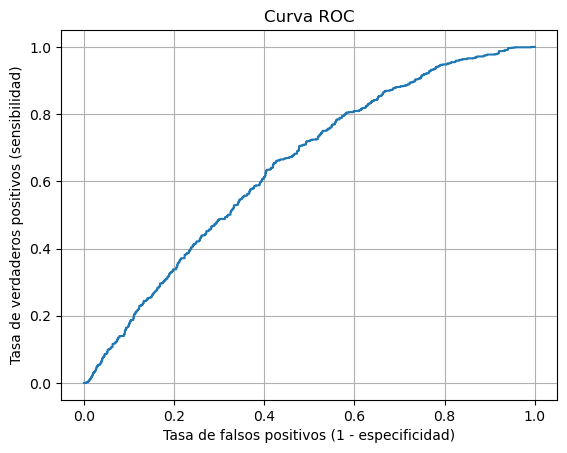

In [13]:
fpr, tpr, thresholds = roc_curve(Y_test, probs)
auc= roc_auc_score(Y_test, probs)
print("AUC: ", auc)

plt.plot(fpr, tpr)
plt.xlabel("Tasa de falsos positivos (1 - especificidad)")
plt.ylabel("Tasa de verdaderos positivos (sensibilidad)")
plt.title("Curva ROC")
plt.grid()
plt.show()

Inciso 6

En el siguiente fragmento de código se recuperan los coeficientes generados por el modelo de LogisticRegression y se almacenan en un DataFrame junto con el nombre de cada variable. Posteriormente, se ordenan de manera descendente con respecto a su valor de coeficiente, para así identificar cuáles variables tienen mayor efecto positivo o negativo en la salida del modelo.

In [12]:
nombres_variables = X_train.columns.tolist()
coefs = model.coef_
df_coefs = pd.DataFrame({
    'Variable': nombres_variables,
    'Coeficiente': coefs[0]
})
df_coefs['Momios']= np.exp(df_coefs['Coeficiente'])
print(df_coefs.sort_values('Coeficiente', ascending=False))

            Variable  Coeficiente     Momios
2       danceability     2.689432  14.723304
5        speechiness     2.309992  10.074342
3             energy     1.262935   3.535783
6       acousticness     0.765908   2.150946
1           explicit     0.166992   1.181745
18             key_6     0.028834   1.029254
0        duration_ms     0.000005   1.000005
10             tempo    -0.002291   0.997711
11    time_signature    -0.043430   0.957500
13             key_1    -0.066192   0.935952
14             key_2    -0.144338   0.865595
22            key_10    -0.146455   0.863765
20             key_8    -0.159604   0.852482
17             key_5    -0.199808   0.818888
4               mode    -0.218770   0.803506
23            key_11    -0.232230   0.792764
21             key_9    -0.249839   0.778926
16             key_4    -0.277122   0.757962
19             key_7    -0.282169   0.754146
12             key_0    -0.412672   0.661880
15             key_3    -0.412762   0.661820
9         

El modelo de regresión logística muestra que las variables con mayor efecto positivo en la probabilidad de que una canción sea popular son:

- Danceability (coef. = 2.68, momio = 14.72)  
- Speechiness (coef. = 2.30, momio = 10.07)  

Esto significa que, a mayor danceability y speechiness, aumenta considerablemente la probabilidad de que una canción sea clasificada como popular.  

Por el contrario, variables como:  

- Liveness (coef. = -1.16, momio = 0.31)  
- Instrumentalness (coef. = -0.94, momio = 0.39)  

Reducen la probabilidad de popularidad, lo que sugiere que canciones más instrumentales o en vivo tienden a ser menos populares para este conjunto de datos.

El análisis de los momios (odds ratio) permite observar el cambio multiplicativo en las probabilidades:  

- Un incremento en danceability multiplica las probabilidades de popularidad por 14.72 veces.  
- Un incremento en speechiness multiplica las probabilidades por 10.07 veces.  
- En contraste, un incremento en instrumentalness reduce las probabilidades a 0.39 veces.  
- De manera similar, un incremento en liveness reduce las probabilidades a 0.31 veces.  

En resumen, los momios confirman y cuantifican la magnitud de los efectos de cada característica ( danceability y speechiness potencian fuertemente la popularidad mientras que instrumentalness y liveness la limitan).


En términos de desempeño, el modelo alcanzó un AUC = 0.646, lo que indica una capacidad de discriminación moderada entre canciones populares y no populares.  

Al variar los umbrales de clasificación, se observó la relación entre sensibilidad y especificidad:  

- Con un umbral de 0.5 se obtuvo un balance razonable (sensibilidad = 0.616, especificidad = 0.597).  
- Con umbrales más altos (0.8) se privilegió la especificidad a costa de la sensibilidad.  
- Con umbrales más bajos (0.3) ocurrió lo contrario. 

En general, los resultados muestran que, aunque el modelo logra captar ciertos patrones asociados a la popularidad, su capacidad predictiva sigue siendo moderada.  
